In [3]:
import matplotlib.pyplot as plt
import procthor
from procthor.simulators import SceneGraphSimulator
import object_search
from object_search.planners import PlanningLoop, OptimisticPlanner, LearnedPlanner
from pathlib import Path


def get_args():
    args = lambda key: None  # noqa
    args.save_dir = '/data/test_logs'
    args.current_seed = 1
    args.resolution = 0.05
    args.do_save_video = True
    args.network_file = '/data/object_search/fcnn.pt'
    return args
    
def test_object_search_learned_planner():
    '''Test object search in ProcTHOR environment with OptimisticPlanner'''
    args = get_args()
    thor_interface = procthor.ThorInterface(args)
    known_graph, known_grid, robot_pose, target_obj_info = thor_interface.gen_map_and_poses()
    learned_simulator = SceneGraphSimulator(known_graph,
                                            args,
                                            target_obj_info,
                                            known_grid,
                                            thor_interface)
    learned_robot = object_search.robot.Robot(robot_pose)
    learned_planner = LearnedPlanner(target_obj_info, args)
    learned_planning_loop = PlanningLoop(target_obj_info, learned_simulator, learned_robot, args=args)
    for _, step_data in enumerate(learned_planning_loop):
        learned_planner.update(
            step_data['observed_graph'],
            step_data['observed_grid'],
            step_data['subgoals'],
            step_data['robot_pose'])
        # print(step_data['observed_graph'].idx_map)
        chosen_subgoal = learned_planner.compute_selected_subgoal()
        learned_planning_loop.set_chosen_subgoal(chosen_subgoal)
    learned_cost, learned_trajectory = object_search.utils.compute_cost_and_trajectory(known_grid,
                                                                                       learned_robot.all_poses)
    cost, trajectory = object_search.utils.compute_cost_and_trajectory(known_grid, learned_robot.all_poses)
    plt.figure(figsize=(8, 8))
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")
    ax = plt.subplot(221)
    plt.title('Whole scene graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)
    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot_pose.x, robot_pose.y, '+', color='red', size=6, rotation=45)
    plt.title('Graph over occupancy grid')
    plt.subplot(223)
    top_down_image = learned_simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down view of the map')
    plt.axis('off')
    plt.subplot(224)
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, learned_robot.all_poses, trajectory, known_graph)
    plt.title(f"Cost: {cost:0.3f}")
    # print('testing')

Target object: ladle
Known locations: ['countertop']
Counter: 0 | Count since last turnaround: 100
Searching in container: countertop
<Pose x:17.000000, y:55.000000, yaw:0.000000>
(17, 55)
 
TOTAL TIME:  0.0006489753723144531


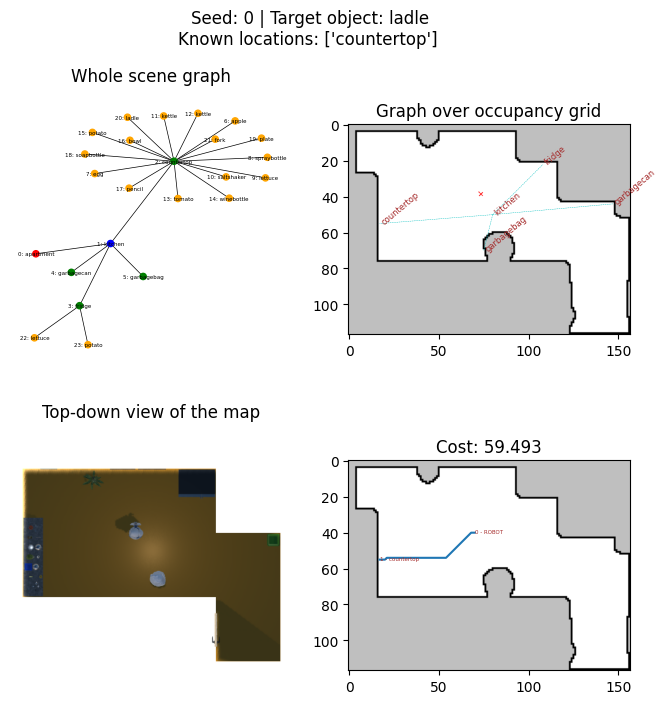

In [4]:
test_object_search_learned_planner()